In [110]:
# Standard library imports
import os

# Third-party library imports
import albumentations as A
import cv2
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image

# TensorFlow/Keras specific imports
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling2D,
    Input,
    MaxPooling2D,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Scikit-learn imports
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_fscore_support,
)


In [2]:
# Download dataset
path = kagglehub.dataset_download("gpiosenka/sports-classification")
print("Dataset path:", path)

# List files inside the dataset
print(os.listdir(path))


Dataset path: /kaggle/input/sports-classification
['EfficientNetB0-100-(224 X 224)- 98.40.h5', 'sports.csv', 'valid', 'test', 'train']


In [3]:
csv_path = "/kaggle/input/sports-classification/sports.csv"
df = pd.read_csv(csv_path)

### Sports.csv
### Table which maps each image to its:

- Class ID
- Filepath
- Label
- Which dataset it belongs ( Train, Test, Validation )

In [4]:
df.head(5)

,class id,filepaths,labels,data set
0,0,train/air hockey/001.jpg,air hockey,train
1,0,train/air hockey/002.jpg,air hockey,train
2,0,train/air hockey/003.jpg,air hockey,train
3,0,train/air hockey/004.jpg,air hockey,train
4,0,train/air hockey/005.jpg,air hockey,train


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14493 entries, 0 to 14492
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   class id   14493 non-null  int64 
 1   filepaths  14493 non-null  object
 2   labels     14493 non-null  object
 3   data set   14493 non-null  object
dtypes: int64(1), object(3)
memory usage: 453.0+ KB


In [6]:
df.isnull().sum()

,0
class id,0
filepaths,0
labels,0
data set,0


### Example of class labels ( Top 30 Most Frequent Sports Classes )

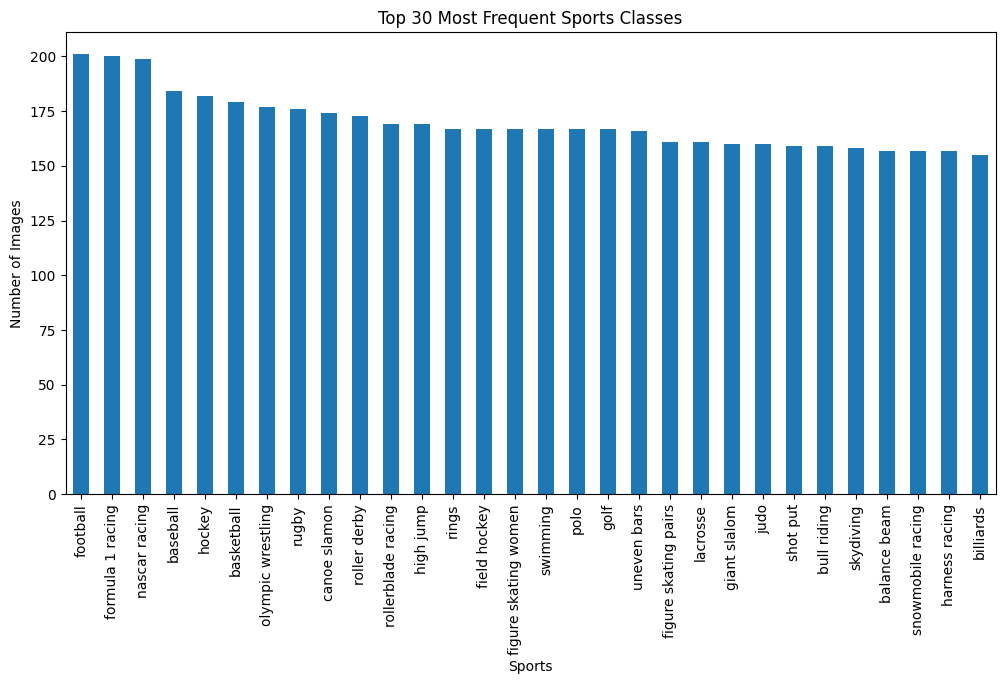

In [7]:
top30 = df['labels'].value_counts().head(30)

# Bar chart
plt.figure(figsize=(12,6))
top30.plot(kind='bar')
plt.title("Top 30 Most Frequent Sports Classes")
plt.xlabel("Sports")
plt.ylabel("Number of Images")
plt.xticks(rotation=90)
plt.show()

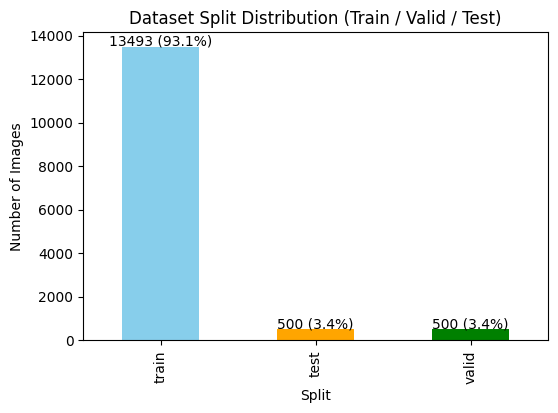

In [28]:
split_counts = df['data set'].value_counts()
total = split_counts.sum()

plt.figure(figsize=(6,4))
bars = split_counts.plot(kind='bar', color=['skyblue','orange','green'])
plt.title("Dataset Split Distribution (Train / Valid / Test)")
plt.xlabel("Split")
plt.ylabel("Number of Images")

for i, count in enumerate(split_counts):
    pct = count / total * 100
    plt.text(i, count + 50, f"{count} ({pct:.1f}%)", ha='center', fontsize=10)

plt.show()

### 2. Model Development

### Image resize:

- Dataset might have images of different sizes
- Neural networks like CNNs require all inputs to have the same shape.
- So we resize all images to a fixed size

In [9]:
img_size = (128, 128)
batch_size = 256 # Mini-Batch Gradient Descent balance between speed and stability.
# SGD (batch = 1) and very low batches create noisy gradients, which acts as regularization, leading to  better generalization.
# Very large batches
# Mini-Batches: Best practice, stable training and efficient computation

In [46]:
import shutil
shutil.rmtree("/kaggle/working/augmented_train", ignore_errors=True)

def augment_training_dataset(original_train_path, augmented_train_path, target_size=(224, 224)):
    """
    Replace original images with augmented versions - same count, just augmented
    """
    # Define augmentation pipeline
    transform = A.Compose([
        A.Rotate(limit=20, p=0.8),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=0, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomScale(scale_limit=0.2, p=0.5),
        A.Resize(target_size[0], target_size[1])
    ])

    # Create output directory
    os.makedirs(augmented_train_path, exist_ok=True)

    # Process each class folder
    for class_name in os.listdir(original_train_path):
        class_path = os.path.join(original_train_path, class_name)
        if not os.path.isdir(class_path):
            continue

        print(f"Processing class: {class_name}")

        output_class_path = os.path.join(augmented_train_path, class_name)
        os.makedirs(output_class_path, exist_ok=True)

        # Process each image in the class
        for img_name in os.listdir(class_path):
            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            img_path = os.path.join(class_path, img_name)

            try:
                # Read image
                image = cv2.imread(img_path)
                if image is None:
                    print(f"Could not read image: {img_path}")
                    continue

                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Create ONE augmented version (no original saved)
                augmented = transform(image=image)['image']

                # Save with same filename as original
                save_path = os.path.join(output_class_path, img_name)
                Image.fromarray(augmented).save(save_path)

            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                continue

    print(f"Augmentation complete! Dataset saved to: {augmented_train_path}")

In [47]:
# Set your paths
original_train_dir = "/kaggle/input/sports-classification/train"
augmented_train_dir = "/kaggle/working/augmented_train"  # or your preferred path
valid_dir = "/kaggle/input/sports-classification/valid"
test_dir = "/kaggle/input/sports-classification/test"

In [49]:
augment_training_dataset(original_train_dir, augmented_train_dir, target_size=img_size)

Processing class: bobsled
Processing class: hurdles
Processing class: snow boarding
Processing class: fly fishing
Processing class: luge
Processing class: sidecar racing
Processing class: ampute football
Processing class: volleyball
Processing class: billiards
Processing class: giant slalom
Processing class: tennis
Processing class: horse racing
Processing class: pole dancing
Processing class: figure skating women
Processing class: rollerblade racing
Processing class: fencing
Processing class: olympic wrestling
Processing class: golf
Processing class: ultimate
Processing class: harness racing
Processing class: football
Processing class: frisbee
Processing class: bungee jumping
Processing class: shot put
Processing class: ice climbing
Processing class: figure skating men
Processing class: rowing
Processing class: bike polo
Processing class: swimming
Processing class: judo
Processing class: axe throwing
Processing class: archery
Processing class: baseball
Processing class: wheelchair bas

In [95]:
simple_datagen = ImageDataGenerator(rescale=1./255)

# Load datasets
train_gen = simple_datagen.flow_from_directory(
    augmented_train_dir,  # Use augmented dataset
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_gen = simple_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = simple_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 13492 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


In [96]:
# Number of classes
num_classes = train_gen.num_classes
class_labels = list(test_gen.class_indices.keys())

### Build CNN Model

In [52]:
model = Sequential([
    # Block 1
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3,3), activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    # Block 3 (optional deeper)
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    # Flatten + Dense layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Model Summary

In [53]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 58, 58, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 27, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     5,538,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,703,172 (21.76 MB)

 Trainable params: 5,703,172 (21.76 MB)

 Non-trainable params: 0 (0.00 B)

In [99]:
# Callbacks
# early_stop = EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     restore_best_weights=True
# )
checkpoint = ModelCheckpoint(
    "best_cnn_model.h5",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max",
    verbose=1
)

In [100]:
# Calculate steps per epoch
steps_per_epoch = train_gen.samples // batch_size
validation_steps = valid_gen.samples // batch_size

In [102]:
# Train the model
print(f"\n🚀 TRAINING MODEL: Custom_CNN")
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[checkpoint],
    verbose=1
)


🚀 TRAINING MODEL: Custom_CNN
Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.5471 - loss: 1.5403
Epoch 1: val_accuracy did not improve from 0.42188
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 281ms/step - accuracy: 0.5472 - loss: 1.5403 - val_accuracy: 0.3711 - val_loss: 2.5721
Epoch 2/50
 1/52 ━━━━━━━━━━━━━━━━━━━━ 12s 252ms/step - accuracy: 0.4883 - loss: 1.6975
Epoch 2: val_accuracy did not improve from 0.42188
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4883 - loss: 1.6975 - val_accuracy: 0.3672 - val_loss: 2.6461
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.5780 - loss: 1.4229
Epoch 3: val_accuracy did not improve from 0.42188
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 266ms/step - accuracy: 0.5779 - loss: 1.4231 - val_accuracy: 0.3633 - val_loss: 2.6382
Epoch 4/50
 1/52 ━━━━━━━━━━━━━━━━━━━━ 12s 251ms/step - accuracy: 0.5703 - loss: 1.4277
Epoch 4: val_accuracy did not improve from 0.42188
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5703 - loss: 1

52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 275ms/step - accuracy: 0.7030 - loss: 0.9549 - val_accuracy: 0.4453 - val_loss: 2.9020
Epoch 30/50
 1/52 ━━━━━━━━━━━━━━━━━━━━ 13s 259ms/step - accuracy: 0.7148 - loss: 0.8858
Epoch 30: val_accuracy did not improve from 0.44531
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7148 - loss: 0.8858 - val_accuracy: 0.3672 - val_loss: 2.9725
Epoch 31/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.7129 - loss: 0.9122
Epoch 31: val_accuracy did not improve from 0.44531
52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 273ms/step - accuracy: 0.7129 - loss: 0.9124 - val_accuracy: 0.3945 - val_loss: 2.7801
Epoch 32/50
 1/52 ━━━━━━━━━━━━━━━━━━━━ 13s 259ms/step - accuracy: 0.6680 - loss: 0.9519
Epoch 32: val_accuracy did not improve from 0.44531
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6680 - loss: 0.9519 - val_accuracy: 0.3750 - val_loss: 3.1943
Epoch 33/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.7191 - loss: 0.9025
Epoch 33: val_accuracy did 

In [103]:
def evaluate_model(model, model_name, history, test_gen, class_labels):
    """
    Comprehensive model evaluation and save results to dictionary
    """
    global model_results
    print(f"\n{'='*60}")
    print(f"EVALUATING MODEL: {model_name}")
    print(f"{'='*60}")

    # --- 1. Test Set Evaluation ---
    test_loss, test_acc = model.evaluate(test_gen, verbose=1)

    # --- 2. Predictions ---
    y_pred = model.predict(test_gen, verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Reset test generator to get true labels
    test_gen.reset()
    y_true = test_gen.classes

    # --- 3. Calculate Metrics ---
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred_classes)

    # Precision, Recall, F1-score
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred_classes, average='macro', zero_division=0
    )
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
        y_true, y_pred_classes, average='micro', zero_division=0
    )
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        y_true, y_pred_classes, average='weighted', zero_division=0
    )

    # Per-class metrics
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        y_true, y_pred_classes, average=None, zero_division=0
    )

    # --- 4. Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred_classes)

    # --- 5. Classification Report ---
    class_report = classification_report(
        y_true, y_pred_classes,
        target_names=class_labels,
        output_dict=True,
        zero_division=0
    )

    # --- 6. Store Results ---
    model_results[model_name] = {
        # Basic metrics
        'test_accuracy': accuracy,
        'test_loss': test_loss,

        # Macro averaging
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,

        # Micro averaging
        'precision_micro': precision_micro,
        'recall_micro': recall_micro,
        'f1_micro': f1_micro,

        # Weighted averaging
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,

        # Per-class metrics
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'f1_per_class': f1_per_class,
        'support_per_class': support_per_class,

        # Additional data
        'confusion_matrix': cm,
        'classification_report': class_report,
        'training_history': history.history,
        'class_labels': class_labels,
        'y_true': y_true,
        'y_pred': y_pred_classes,
        'y_pred_proba': y_pred
    }

    # --- 7. Print Summary ---
    print(f"\n📊 MODEL PERFORMANCE SUMMARY:")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"\n🎯 MACRO AVERAGES:")
    print(f"Precision: {precision_macro:.4f}")
    print(f"Recall: {recall_macro:.4f}")
    print(f"F1-Score: {f1_macro:.4f}")
    print(f"\n⚖️ MICRO AVERAGES:")
    print(f"Precision: {precision_micro:.4f}")
    print(f"Recall: {recall_micro:.4f}")
    print(f"F1-Score: {f1_micro:.4f}")
    print(f"\n📈 WEIGHTED AVERAGES:")
    print(f"Precision: {precision_weighted:.4f}")
    print(f"Recall: {recall_weighted:.4f}")
    print(f"F1-Score: {f1_weighted:.4f}")

    return model_results[model_name]

In [104]:
def plot_training_history(model_name, history, save_plots=True):
    """
    Plot training/validation accuracy and loss over epochs
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history['accuracy'], label='Training Accuracy', linewidth=2)
    ax1.plot(history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_title(f'{model_name} - Training & Validation Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot loss
    ax2.plot(history['loss'], label='Training Loss', linewidth=2)
    ax2.plot(history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title(f'{model_name} - Training & Validation Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_plots:
        plt.savefig(f'{model_name}_training_history.png', dpi=300, bbox_inches='tight')

    plt.show()


In [105]:
def plot_confusion_matrix(model_name, cm, class_labels, save_plots=True):
    """
    Plot confusion matrix heatmap
    """
    plt.figure(figsize=(12, 10))

    # Create heatmap
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)

    plt.title(f'{model_name} - Confusion Matrix', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    if save_plots:
        plt.savefig(f'{model_name}_confusion_matrix.png', dpi=300, bbox_inches='tight')

    plt.show()

In [106]:
def plot_per_class_metrics(model_name, precision_per_class, recall_per_class, f1_per_class, class_labels, save_plots=True):
    """
    Plot per-class precision, recall, and F1-score
    """
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))

    x_pos = np.arange(len(class_labels))

    # Precision
    ax1.bar(x_pos, precision_per_class, alpha=0.7, color='skyblue')
    ax1.set_title(f'{model_name} - Precision per Class', fontweight='bold')
    ax1.set_ylabel('Precision')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(class_labels, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3)

    # Recall
    ax2.bar(x_pos, recall_per_class, alpha=0.7, color='lightcoral')
    ax2.set_title(f'{model_name} - Recall per Class', fontweight='bold')
    ax2.set_ylabel('Recall')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(class_labels, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)

    # F1-Score
    ax3.bar(x_pos, f1_per_class, alpha=0.7, color='lightgreen')
    ax3.set_title(f'{model_name} - F1-Score per Class', fontweight='bold')
    ax3.set_ylabel('F1-Score')
    ax3.set_xlabel('Classes')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(class_labels, rotation=45, ha='right')
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_plots:
        plt.savefig(f'{model_name}_per_class_metrics.png', dpi=300, bbox_inches='tight')

    plt.show()

### Model 1 Evaluation


EVALUATING MODEL: Custom_CNN
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 396ms/step - accuracy: 0.3994 - loss: 3.1638
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step

📊 MODEL PERFORMANCE SUMMARY:
Test Accuracy: 0.3960
Test Loss: 3.1730

🎯 MACRO AVERAGES:
Precision: 0.4225
Recall: 0.3960
F1-Score: 0.3768

⚖️ MICRO AVERAGES:
Precision: 0.3960
Recall: 0.3960
F1-Score: 0.3960

📈 WEIGHTED AVERAGES:
Precision: 0.4225
Recall: 0.3960
F1-Score: 0.3768

📊 GENERATING PLOTS FOR Custom_CNN


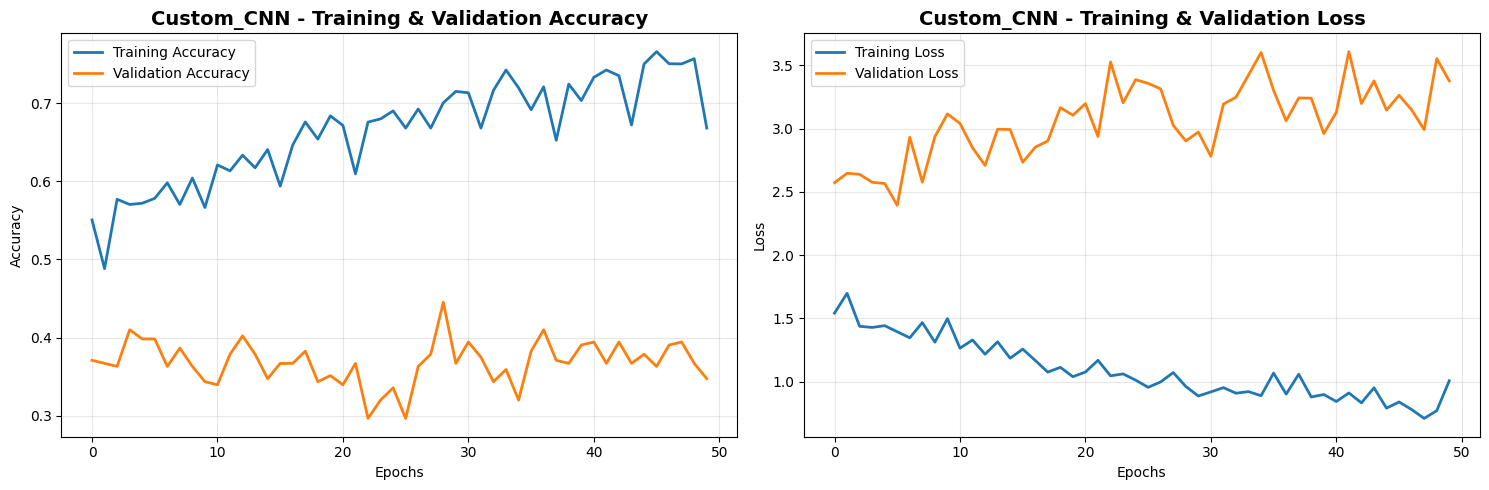

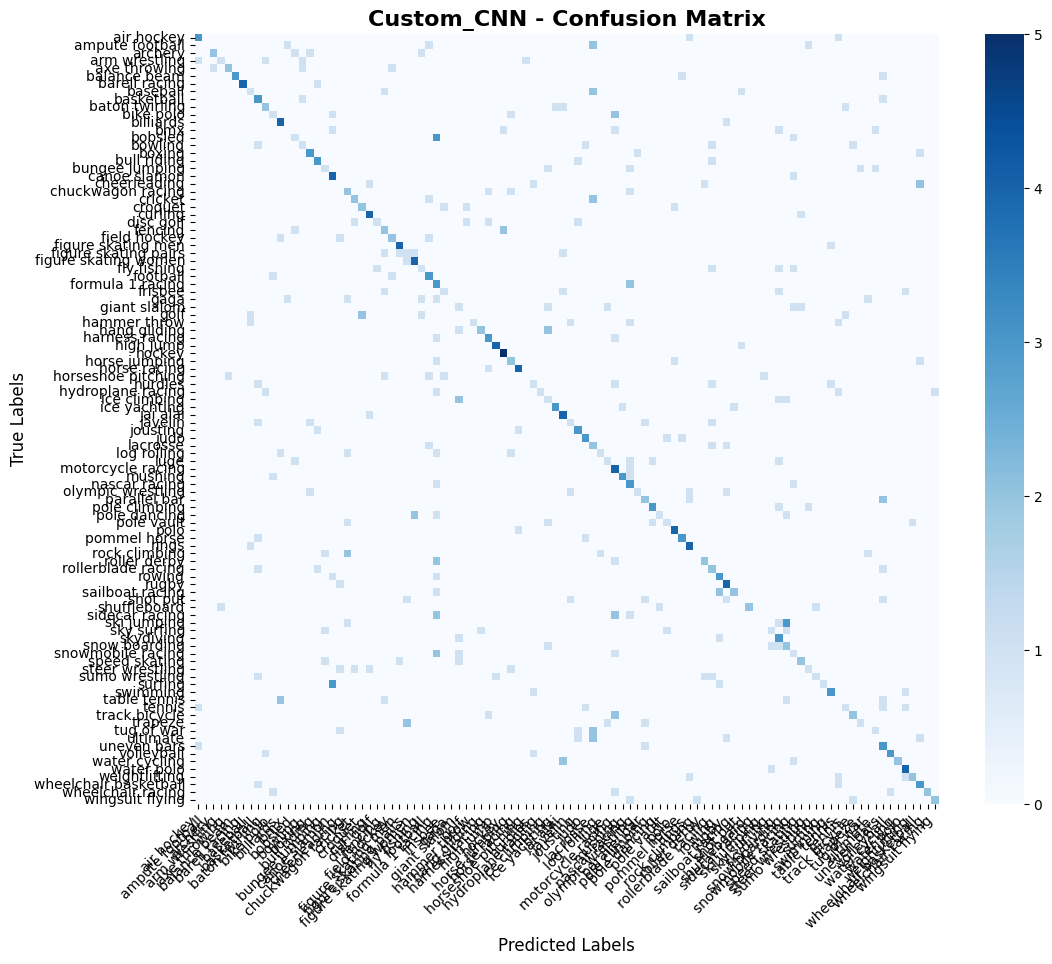

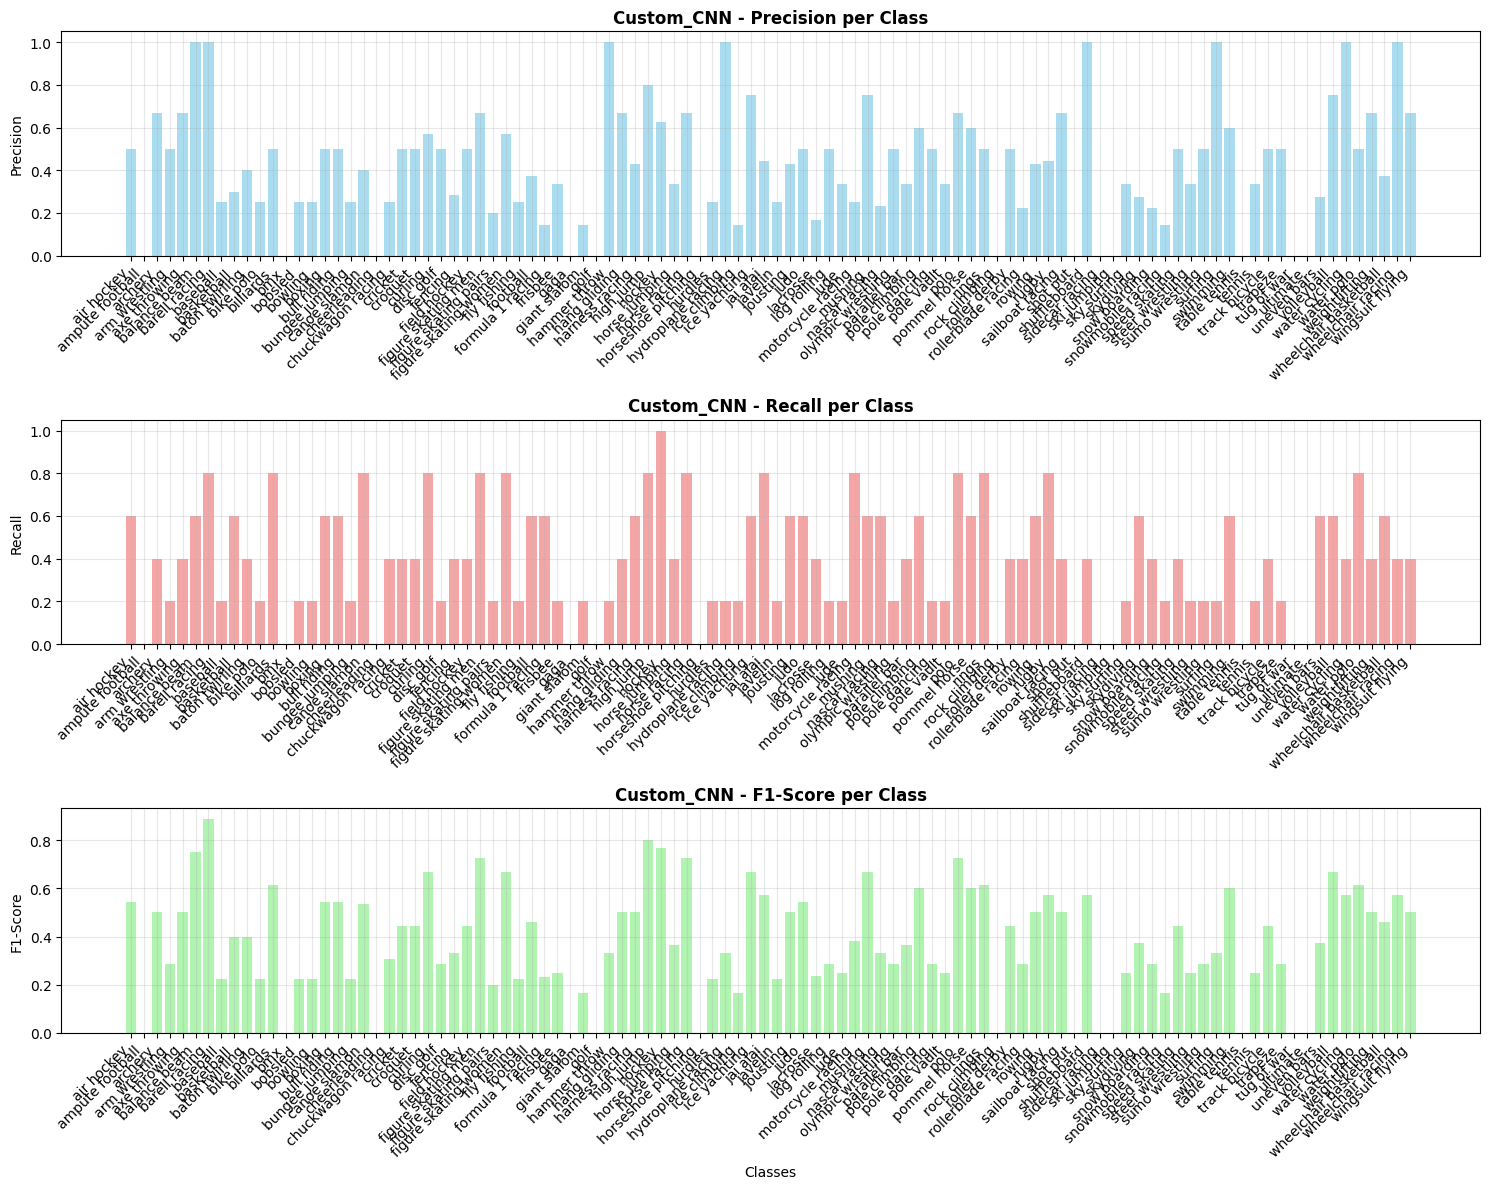


📋 DETAILED CLASSIFICATION REPORT FOR Custom_CNN:
                       precision    recall  f1-score   support

           air hockey     0.5000    0.6000    0.5455         5
      ampute football     0.0000    0.0000    0.0000         5
              archery     0.6667    0.4000    0.5000         5
        arm wrestling     0.5000    0.2000    0.2857         5
         axe throwing     0.6667    0.4000    0.5000         5
         balance beam     1.0000    0.6000    0.7500         5
        barell racing     1.0000    0.8000    0.8889         5
             baseball     0.2500    0.2000    0.2222         5
           basketball     0.3000    0.6000    0.4000         5
       baton twirling     0.4000    0.4000    0.4000         5
            bike polo     0.2500    0.2000    0.2222         5
            billiards     0.5000    0.8000    0.6154         5
                  bmx     0.0000    0.0000    0.0000         5
              bobsled     0.2500    0.2000    0.2222         5
    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [107]:

# Evaluate and store results for model 1
model_name = "Custom_CNN"
results = evaluate_model(model, model_name, history, test_gen, class_labels)

# Generate all required plots
print(f"\n📊 GENERATING PLOTS FOR {model_name}")

# 1. Training history plots
plot_training_history(model_name, history.history)

# 2. Confusion matrix
plot_confusion_matrix(model_name, results['confusion_matrix'], class_labels)

# 3. Per-class metrics
plot_per_class_metrics(
    model_name,
    results['precision_per_class'],
    results['recall_per_class'],
    results['f1_per_class'],
    class_labels
)

# 4. Print detailed classification report
print(f"\n📋 DETAILED CLASSIFICATION REPORT FOR {model_name}:")
print("="*80)
print(classification_report(
    results['y_true'],
    results['y_pred'],
    target_names=class_labels,
    digits=4
))

print(f"\n✅ Model 1 evaluation complete!")
print(f"Results saved in: model_results['{model_name}']")

### Model 2:

In [78]:
# Model 2: Deeper architecture with more filters
model_2 = Sequential([
    # Block 1 - Start with slightly more filters
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    Conv2D(64, (3,3), activation='relu'),  # Increase filters faster
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),  # Slightly higher dropout

    # Block 2
    Conv2D(128, (3,3), activation='relu'),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.4),  # Higher dropout

    # Block 3
    Conv2D(256, (3,3), activation='relu'),
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.4),

    # Block 4 - Additional but smaller
    Conv2D(256, (3,3), activation='relu'),  # Same filters as block 3
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),

    # Flatten + Dense layers
    Flatten(),
    Dense(512, activation='relu'),  # More neurons than model 1
    Dropout(0.5),
    Dense(128, activation='relu'),  # Additional dense layer
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])


In [79]:
from tensorflow.keras.optimizers import RMSprop

model_2.compile(
    optimizer=RMSprop(learning_rate=0.0005),  # Lower learning rate, different optimizer
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_2.summary()

# Callbacks for model 2
early_stop_2 = EarlyStopping(
    monitor='val_loss',
    patience=7,  # More patience due to lower learning rate
    restore_best_weights=True
)
checkpoint_2 = ModelCheckpoint(
    "best_cnn_model_2.h5",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max",
    verbose=1
)

# Calculate steps (using same batch size as model 1)
steps_per_epoch_2 = train_gen.samples // batch_size
validation_steps_2 = valid_gen.samples // batch_size

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 58, 58, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 27, 27, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 10, 10, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,072,036 (19.35 MB)

 Trainable params: 5,072,036 (19.35 MB)

 Non-trainable params: 0 (0.00 B)

In [81]:
history_2 = model_2.fit(
    train_gen,  # Use same generator
    validation_data=valid_gen,  # Use same generator
    epochs=50,
    steps_per_epoch=steps_per_epoch_2,
    validation_steps=validation_steps_2,
    callbacks=[early_stop_2, checkpoint_2],
    verbose=1
)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0102 - loss: 4.6086
Epoch 1: val_accuracy improved from -inf to 0.00781, saving model to best_cnn_model_2.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.0102 - loss: 4.6085 - val_accuracy: 0.0078 - val_loss: 4.5903
Epoch 2/50
 1/52 ━━━━━━━━━━━━━━━━━━━━ 27s 545ms/step - accuracy: 0.0156 - loss: 4.5849

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.00781 to 0.01953, saving model to best_cnn_model_2.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0156 - loss: 4.5849 - val_accuracy: 0.0195 - val_loss: 4.5951
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.0152 - loss: 4.5858
Epoch 3: val_accuracy improved from 0.01953 to 0.02344, saving model to best_cnn_model_2.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 74s 561ms/step - accuracy: 0.0152 - loss: 4.5856 - val_accuracy: 0.0234 - val_loss: 4.5708
Epoch 4/50
 1/52 ━━━━━━━━━━━━━━━━━━━━ 28s 552ms/step - accuracy: 0.0039 - loss: 4.5687
Epoch 4: val_accuracy did not improve from 0.02344
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0039 - loss: 4.5687 - val_accuracy: 0.0195 - val_loss: 4.5408
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.0181 - loss: 4.5440
Epoch 5: val_accuracy improved from 0.02344 to 0.02734, saving model to best_cnn_model_2.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 564ms/step - accuracy: 0.0181 - loss: 4.5438 - val_accuracy: 0.0273 - val_loss: 4.5462
Epoch 6/50
 1/52 ━━━━━━━━━━━━━━━━━━━━ 27s 545ms/step - accuracy: 0.0312 - loss: 4.4994
Epoch 6: val_accuracy improved from 0.02734 to 0.03906, saving model to best_cnn_model_2.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0312 - loss: 4.4994 - val_accuracy: 0.0391 - val_loss: 4.4727
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.0278 - loss: 4.4831
Epoch 7: val_accuracy improved from 0.03906 to 0.05078, saving model to best_cnn_model_2.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 40s 568ms/step - accuracy: 0.0278 - loss: 4.4829 - val_accuracy: 0.0508 - val_loss: 4.4382
Epoch 8/50
 1/52 ━━━━━━━━━━━━━━━━━━━━ 28s 553ms/step - accuracy: 0.0234 - loss: 4.4104
Epoch 8: val_accuracy did not improve from 0.05078
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0234 - loss: 4.4104 - val_accuracy: 0.0430 - val_loss: 4.4117
Epoch 9/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.0269 - loss: 4.4052
Epoch 9: val_accuracy did not improve from 0.05078
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 784ms/step - accuracy: 0.0269 - loss: 4.4051 - val_accuracy: 0.0352 - val_loss: 4.4721
Epoch 10/50
 1/52 ━━━━━━━━━━━━━━━━━━━━ 27s 541ms/step - accuracy: 0.0391 - loss: 4.3999
Epoch 10: val_accuracy did not improve from 0.05078
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0391 - loss: 4.3999 - val_accuracy: 0.0234 - val_loss: 4.3488
Epoch 11/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.0358 - loss: 4.3550
Epoch 11: val_accuracy improve

52/52 ━━━━━━━━━━━━━━━━━━━━ 69s 558ms/step - accuracy: 0.0357 - loss: 4.3550 - val_accuracy: 0.0547 - val_loss: 4.2683
Epoch 12/50
 1/52 ━━━━━━━━━━━━━━━━━━━━ 27s 540ms/step - accuracy: 0.0234 - loss: 4.3385
Epoch 12: val_accuracy did not improve from 0.05469
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.0234 - loss: 4.3385 - val_accuracy: 0.0469 - val_loss: 4.3021
Epoch 13/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.0337 - loss: 4.3276
Epoch 13: val_accuracy did not improve from 0.05469
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 563ms/step - accuracy: 0.0338 - loss: 4.3275 - val_accuracy: 0.0430 - val_loss: 4.2596
Epoch 14/50
 1/52 ━━━━━━━━━━━━━━━━━━━━ 27s 544ms/step - accuracy: 0.0391 - loss: 4.2548
Epoch 14: val_accuracy did not improve from 0.05469
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0391 - loss: 4.2548 - val_accuracy: 0.0547 - val_loss: 4.2168
Epoch 15/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.0331 - loss: 4.2955
Epoch 15: val_accuracy did

52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 570ms/step - accuracy: 0.0420 - loss: 4.2498 - val_accuracy: 0.0742 - val_loss: 4.1807
Epoch 18/50
 1/52 ━━━━━━━━━━━━━━━━━━━━ 27s 540ms/step - accuracy: 0.0117 - loss: 4.2818
Epoch 18: val_accuracy did not improve from 0.07422
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0117 - loss: 4.2818 - val_accuracy: 0.0703 - val_loss: 4.2668
Epoch 19/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.0413 - loss: 4.2374
Epoch 19: val_accuracy did not improve from 0.07422
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 599ms/step - accuracy: 0.0414 - loss: 4.2370 - val_accuracy: 0.0586 - val_loss: 4.1852
Epoch 20/50
 1/52 ━━━━━━━━━━━━━━━━━━━━ 27s 547ms/step - accuracy: 0.0508 - loss: 4.2104
Epoch 20: val_accuracy improved from 0.07422 to 0.09375, saving model to best_cnn_model_2.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.0508 - loss: 4.2104 - val_accuracy: 0.0938 - val_loss: 4.2086
Epoch 21/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.0470 - loss: 4.1859
Epoch 21: val_accuracy improved from 0.09375 to 0.10156, saving model to best_cnn_model_2.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 573ms/step - accuracy: 0.0470 - loss: 4.1858 - val_accuracy: 0.1016 - val_loss: 4.0621
Epoch 22/50
 1/52 ━━━━━━━━━━━━━━━━━━━━ 27s 547ms/step - accuracy: 0.0430 - loss: 4.2041
Epoch 22: val_accuracy did not improve from 0.10156
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0430 - loss: 4.2041 - val_accuracy: 0.0898 - val_loss: 4.1012
Epoch 23/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.0559 - loss: 4.1393
Epoch 23: val_accuracy improved from 0.10156 to 0.10938, saving model to best_cnn_model_2.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 792ms/step - accuracy: 0.0559 - loss: 4.1390 - val_accuracy: 0.1094 - val_loss: 3.9503
Epoch 24/50
 1/52 ━━━━━━━━━━━━━━━━━━━━ 27s 543ms/step - accuracy: 0.0547 - loss: 4.0485
Epoch 24: val_accuracy did not improve from 0.10938
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.0547 - loss: 4.0485 - val_accuracy: 0.0898 - val_loss: 4.1145
Epoch 25/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.0640 - loss: 4.0689
Epoch 25: val_accuracy did not improve from 0.10938
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 557ms/step - accuracy: 0.0640 - loss: 4.0687 - val_accuracy: 0.1094 - val_loss: 4.0893
Epoch 26/50
 1/52 ━━━━━━━━━━━━━━━━━━━━ 27s 547ms/step - accuracy: 0.0547 - loss: 4.1310
Epoch 26: val_accuracy did not improve from 0.10938
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0547 - loss: 4.1310 - val_accuracy: 0.0859 - val_loss: 4.0316
Epoch 27/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.0650 - loss: 4.0259
Epoch 27: val_accuracy did

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0664 - loss: 4.0541 - val_accuracy: 0.1172 - val_loss: 3.8751
Epoch 29/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.0742 - loss: 3.9741
Epoch 29: val_accuracy did not improve from 0.11719
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 587ms/step - accuracy: 0.0742 - loss: 3.9739 - val_accuracy: 0.1094 - val_loss: 4.0585
Epoch 30/50
 1/52 ━━━━━━━━━━━━━━━━━━━━ 28s 555ms/step - accuracy: 0.0547 - loss: 4.0202
Epoch 30: val_accuracy improved from 0.11719 to 0.12500, saving model to best_cnn_model_2.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0547 - loss: 4.0202 - val_accuracy: 0.1250 - val_loss: 3.9225
Epoch 31/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.0814 - loss: 3.9183
Epoch 31: val_accuracy improved from 0.12500 to 0.14844, saving model to best_cnn_model_2.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 564ms/step - accuracy: 0.0814 - loss: 3.9184 - val_accuracy: 0.1484 - val_loss: 3.7189
Epoch 32/50
 1/52 ━━━━━━━━━━━━━━━━━━━━ 27s 539ms/step - accuracy: 0.1172 - loss: 3.6938
Epoch 32: val_accuracy did not improve from 0.14844
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1172 - loss: 3.6938 - val_accuracy: 0.1250 - val_loss: 3.8679
Epoch 33/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.0910 - loss: 3.8686
Epoch 33: val_accuracy did not improve from 0.14844
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 784ms/step - accuracy: 0.0910 - loss: 3.8686 - val_accuracy: 0.1016 - val_loss: 3.7910
Epoch 34/50
 1/52 ━━━━━━━━━━━━━━━━━━━━ 28s 552ms/step - accuracy: 0.0586 - loss: 3.8805
Epoch 34: val_accuracy did not improve from 0.14844
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0586 - loss: 3.8805 - val_accuracy: 0.1445 - val_loss: 3.7316
Epoch 35/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.1006 - loss: 3.8181
Epoch 35: val_accuracy did

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0781 - loss: 3.8418 - val_accuracy: 0.1523 - val_loss: 3.6675
Epoch 37/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.1107 - loss: 3.7723
Epoch 37: val_accuracy did not improve from 0.15234
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 781ms/step - accuracy: 0.1107 - loss: 3.7720 - val_accuracy: 0.1289 - val_loss: 3.6875
Epoch 38/50
 1/52 ━━━━━━━━━━━━━━━━━━━━ 27s 537ms/step - accuracy: 0.1172 - loss: 3.6590
Epoch 38: val_accuracy improved from 0.15234 to 0.16016, saving model to best_cnn_model_2.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1172 - loss: 3.6590 - val_accuracy: 0.1602 - val_loss: 3.5907
Epoch 39/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.1144 - loss: 3.7381
Epoch 39: val_accuracy improved from 0.16016 to 0.17188, saving model to best_cnn_model_2.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 69s 556ms/step - accuracy: 0.1145 - loss: 3.7376 - val_accuracy: 0.1719 - val_loss: 3.4538
Epoch 40/50
 1/52 ━━━━━━━━━━━━━━━━━━━━ 27s 539ms/step - accuracy: 0.1367 - loss: 3.5097
Epoch 40: val_accuracy did not improve from 0.17188
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1367 - loss: 3.5097 - val_accuracy: 0.1406 - val_loss: 3.5103
Epoch 41/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.1244 - loss: 3.6626
Epoch 41: val_accuracy improved from 0.17188 to 0.19141, saving model to best_cnn_model_2.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 582ms/step - accuracy: 0.1245 - loss: 3.6624 - val_accuracy: 0.1914 - val_loss: 3.4372
Epoch 42/50
 1/52 ━━━━━━━━━━━━━━━━━━━━ 27s 545ms/step - accuracy: 0.1367 - loss: 3.6697
Epoch 42: val_accuracy did not improve from 0.19141
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.1367 - loss: 3.6697 - val_accuracy: 0.1523 - val_loss: 3.6602
Epoch 43/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.1395 - loss: 3.6016
Epoch 43: val_accuracy did not improve from 0.19141
52/52 ━━━━━━━━━━━━━━━━━━━━ 37s 559ms/step - accuracy: 0.1395 - loss: 3.6013 - val_accuracy: 0.1836 - val_loss: 3.4744
Epoch 44/50
 1/52 ━━━━━━━━━━━━━━━━━━━━ 27s 544ms/step - accuracy: 0.1016 - loss: 3.6943
Epoch 44: val_accuracy did not improve from 0.19141
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1016 - loss: 3.6943 - val_accuracy: 0.1680 - val_loss: 3.4868
Epoch 45/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.1433 - loss: 3.5357
Epoch 45: val_accuracy imp

52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 794ms/step - accuracy: 0.1433 - loss: 3.5357 - val_accuracy: 0.2188 - val_loss: 3.3460
Epoch 46/50
 1/52 ━━━━━━━━━━━━━━━━━━━━ 27s 544ms/step - accuracy: 0.1758 - loss: 3.3558
Epoch 46: val_accuracy did not improve from 0.21875
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1758 - loss: 3.3558 - val_accuracy: 0.1797 - val_loss: 3.4005
Epoch 47/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.1512 - loss: 3.4828
Epoch 47: val_accuracy did not improve from 0.21875
52/52 ━━━━━━━━━━━━━━━━━━━━ 82s 819ms/step - accuracy: 0.1513 - loss: 3.4829 - val_accuracy: 0.1953 - val_loss: 3.2650
Epoch 48/50
 1/52 ━━━━━━━━━━━━━━━━━━━━ 28s 556ms/step - accuracy: 0.1992 - loss: 3.4053
Epoch 48: val_accuracy did not improve from 0.21875
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1992 - loss: 3.4053 - val_accuracy: 0.2148 - val_loss: 3.2964
Epoch 49/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.1669 - loss: 3.4392
Epoch 49: val_accuracy did


EVALUATING MODEL: CNN_RMSprop_Deeper
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step - accuracy: 0.2419 - loss: 3.1947
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 417ms/step

📊 MODEL PERFORMANCE SUMMARY:
Test Accuracy: 0.2320
Test Loss: 3.2068

🎯 MACRO AVERAGES:
Precision: 0.1982
Recall: 0.2320
F1-Score: 0.1867

⚖️ MICRO AVERAGES:
Precision: 0.2320
Recall: 0.2320
F1-Score: 0.2320

📈 WEIGHTED AVERAGES:
Precision: 0.1982
Recall: 0.2320
F1-Score: 0.1867

📊 GENERATING PLOTS FOR CNN_RMSprop_Deeper


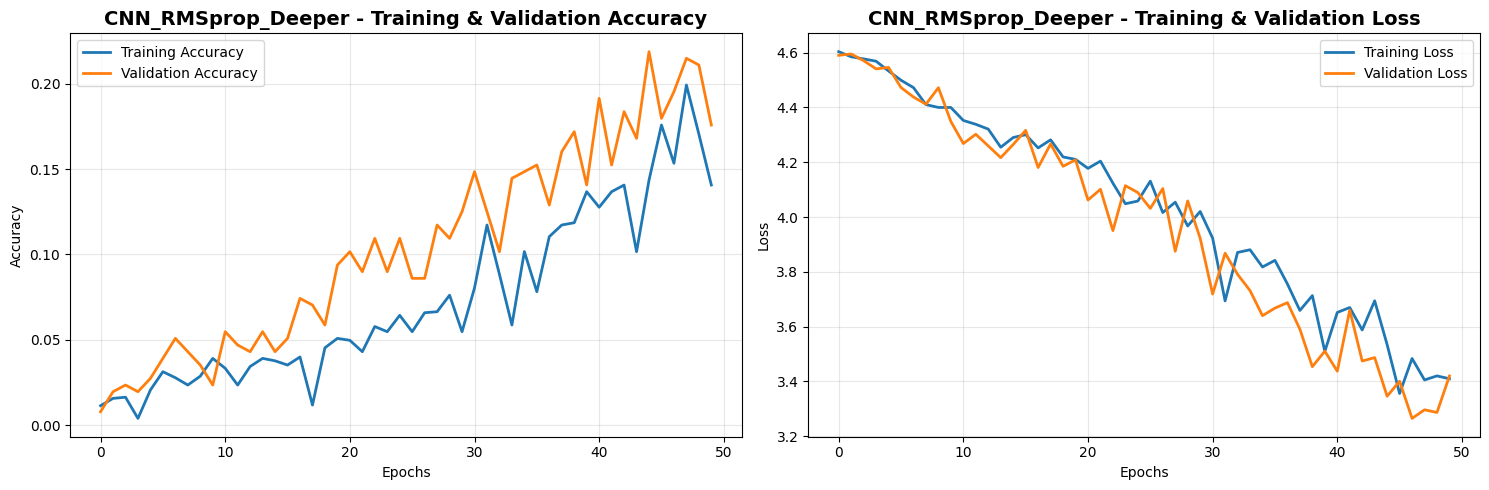

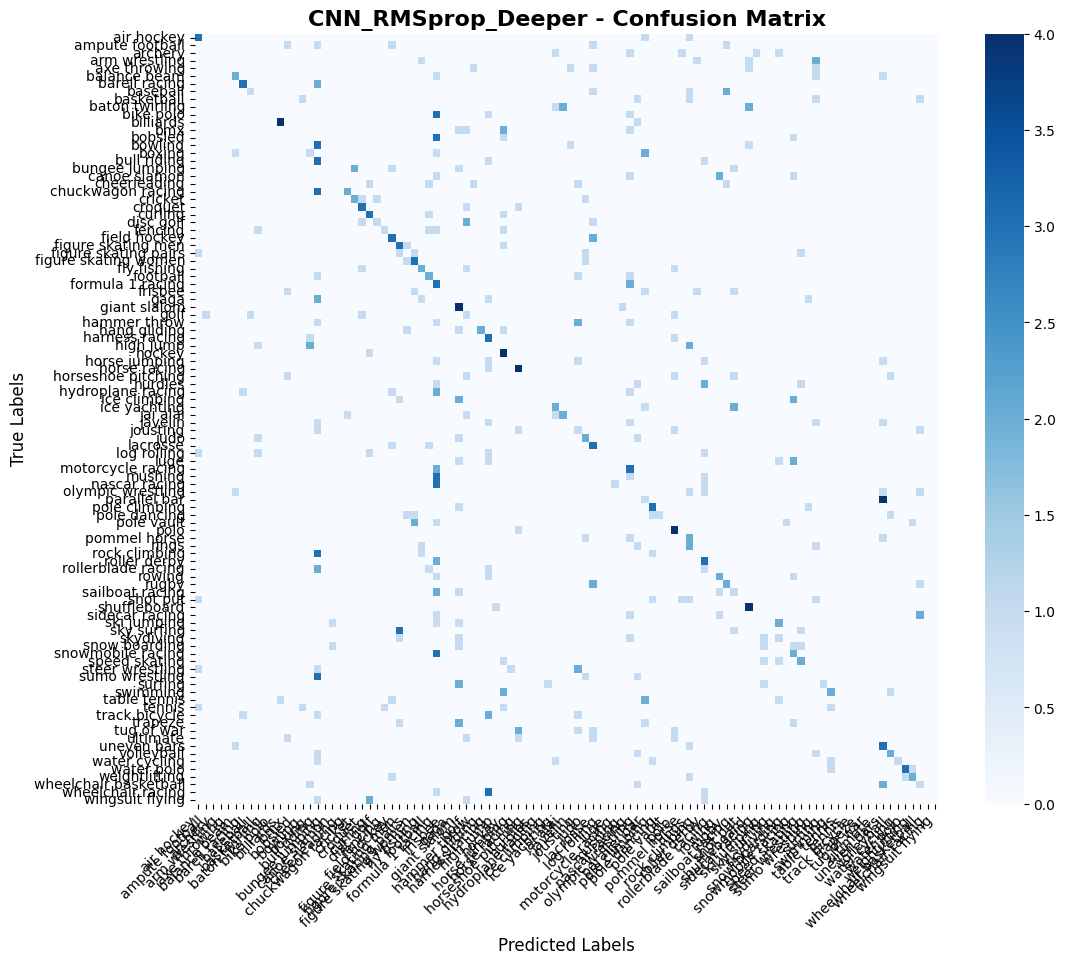

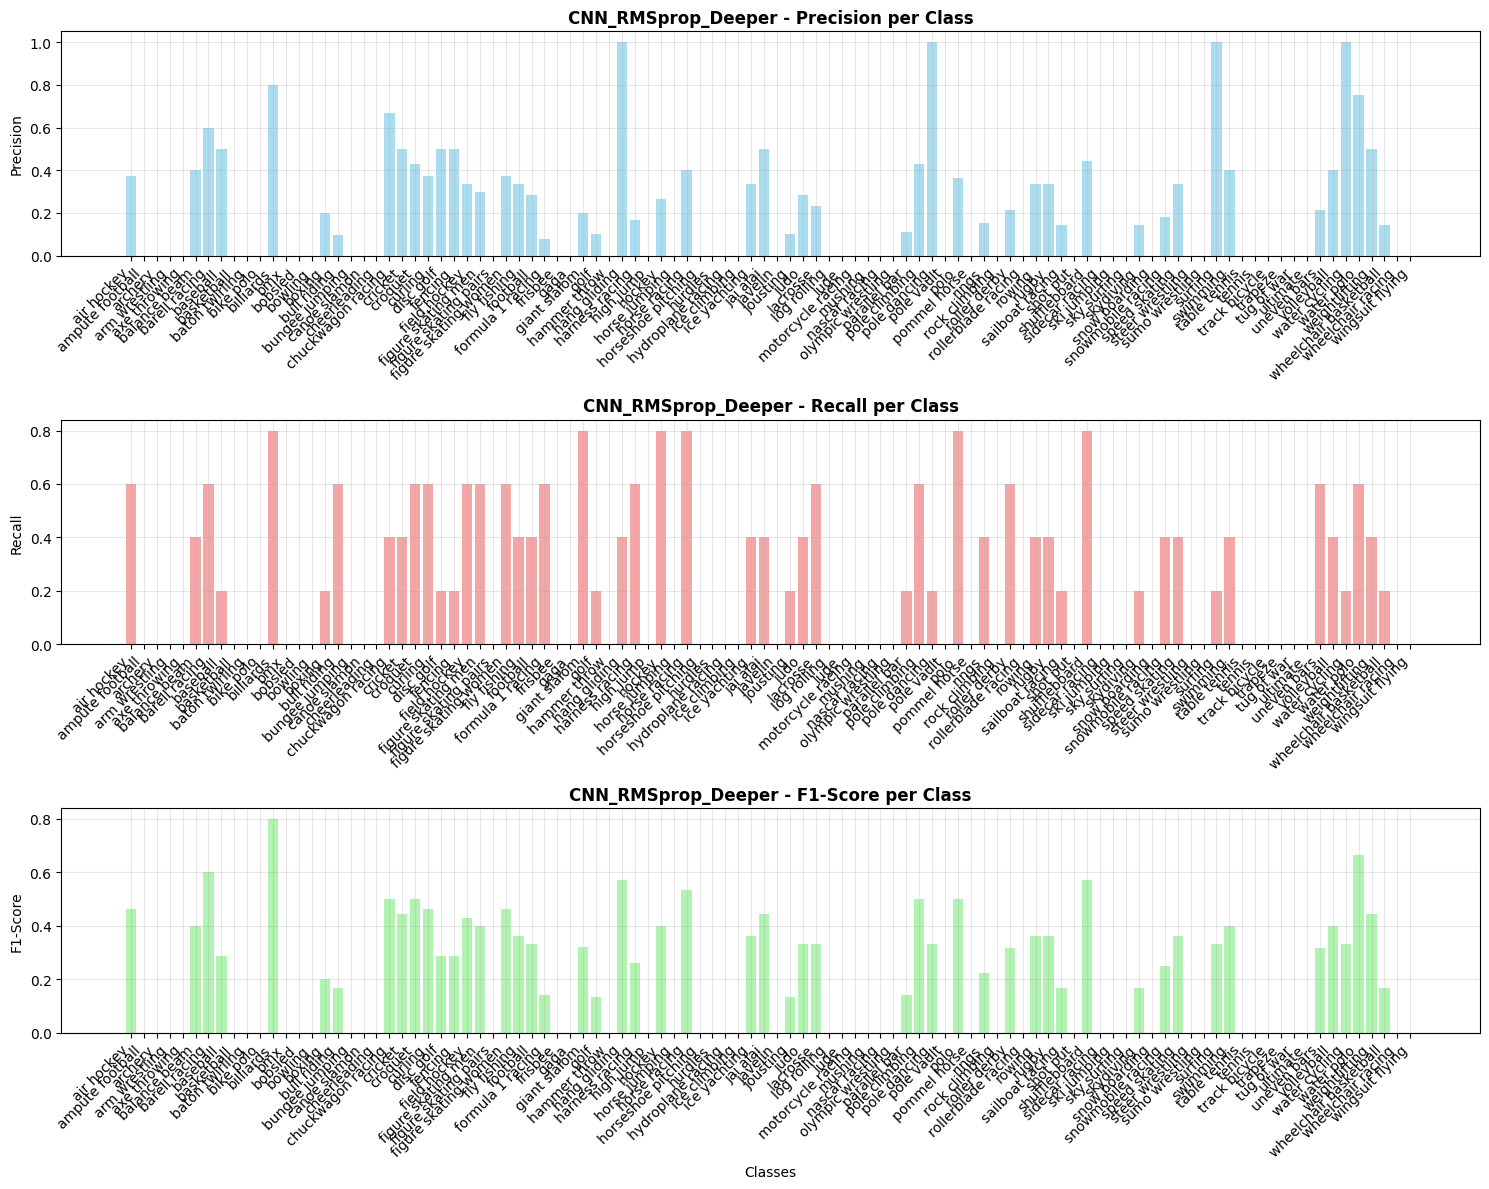


📋 DETAILED CLASSIFICATION REPORT FOR CNN_RMSprop_Deeper:
                       precision    recall  f1-score   support

           air hockey     0.3750    0.6000    0.4615         5
      ampute football     0.0000    0.0000    0.0000         5
              archery     0.0000    0.0000    0.0000         5
        arm wrestling     0.0000    0.0000    0.0000         5
         axe throwing     0.0000    0.0000    0.0000         5
         balance beam     0.4000    0.4000    0.4000         5
        barell racing     0.6000    0.6000    0.6000         5
             baseball     0.5000    0.2000    0.2857         5
           basketball     0.0000    0.0000    0.0000         5
       baton twirling     0.0000    0.0000    0.0000         5
            bike polo     0.0000    0.0000    0.0000         5
            billiards     0.8000    0.8000    0.8000         5
                  bmx     0.0000    0.0000    0.0000         5
              bobsled     0.0000    0.0000    0.0000       

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [109]:
# Evaluate and store results for model 2
model_name_2 = "CNN_RMSprop_Deeper"
results_2 = evaluate_model(model_2, model_name_2, history_2, test_gen, class_labels)  # Use same test_gen

# Generate plots for model 2
print(f"\n📊 GENERATING PLOTS FOR {model_name_2}")

# 1. Training history plots
plot_training_history(model_name_2, history_2.history)

# 2. Confusion matrix
plot_confusion_matrix(model_name_2, results_2['confusion_matrix'], class_labels)

# 3. Per-class metrics
plot_per_class_metrics(
    model_name_2,
    results_2['precision_per_class'],
    results_2['recall_per_class'],
    results_2['f1_per_class'],
    class_labels
)

# 4. Print detailed classification report
print(f"\n📋 DETAILED CLASSIFICATION REPORT FOR {model_name_2}:")
print("="*80)
print(classification_report(
    results_2['y_true'],
    results_2['y_pred'],
    target_names=class_labels,
    digits=4
))

### Model 3:

In [83]:
print("\n" + "="*60)
print("TRAINING MODEL 3: CNN_Adam_HighCapacity")
print("="*60)

from tensorflow.keras.layers import BatchNormalization


TRAINING MODEL 3: CNN_Adam_HighCapacity


In [89]:
model_3 = Sequential([
    # Block 1 - Start with more filters than Model 1
    Conv2D(64, (3,3), activation='relu', input_shape=(128,128,3)),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),  # Lower dropout to allow more learning

    # Block 2 - More filters
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),  # Moderate dropout

    # Block 3 - More filters than Model 1
    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),  # Moderate dropout

    # Flatten + Dense layers - More capacity
    Flatten(),
    Dense(512, activation='relu'),  # Double the neurons of Model 1
    BatchNormalization(),
    Dropout(0.4),  # Moderate dropout
    Dense(256, activation='relu'),  # Additional layer for more capacity
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile with Adam and moderate learning rate (between Model 1 and failed Model 3)
model_3.compile(
    optimizer=Adam(learning_rate=0.0007),  # Slightly higher than default but not too high
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_3.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 126, 126, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 126, 126, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 124, 124, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 58, 58, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 27, 27, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 27, 27, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,181,156 (76.99 MB)

 Trainable params: 20,179,236 (76.98 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [90]:
# Callbacks for model 3
early_stop_3 = EarlyStopping(
    monitor='val_loss',
    patience=8,  # More patience for this larger model
    restore_best_weights=True
)
checkpoint_3 = ModelCheckpoint(
    "best_cnn_model_3.h5",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max",
    verbose=1
)

steps_per_epoch_3 = train_gen.samples // batch_size
validation_steps_3 = valid_gen.samples // batch_size

In [91]:
history_3 = model_3.fit(
    train_gen,  # Use same generators
    validation_data=valid_gen,
    epochs=30,
    steps_per_epoch=steps_per_epoch_3,
    validation_steps=validation_steps_3,
    callbacks=[early_stop_3, checkpoint_3],
    verbose=1
)

Epoch 1/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 765ms/step - accuracy: 0.0320 - loss: 4.7502
Epoch 1: val_accuracy improved from -inf to 0.01562, saving model to best_cnn_model_3.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 55s 845ms/step - accuracy: 0.0324 - loss: 4.7441 - val_accuracy: 0.0156 - val_loss: 4.9721
Epoch 2/30
 1/52 ━━━━━━━━━━━━━━━━━━━━ 32s 643ms/step - accuracy: 0.0703 - loss: 3.9938

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.01562
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.0703 - loss: 3.9938 - val_accuracy: 0.0117 - val_loss: 4.9282
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.1261 - loss: 3.7517
Epoch 3: val_accuracy did not improve from 0.01562
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 785ms/step - accuracy: 0.1264 - loss: 3.7500 - val_accuracy: 0.0156 - val_loss: 5.1503
Epoch 4/30
 1/52 ━━━━━━━━━━━━━━━━━━━━ 32s 646ms/step - accuracy: 0.1836 - loss: 3.4670
Epoch 4: val_accuracy did not improve from 0.01562
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1836 - loss: 3.4670 - val_accuracy: 0.0156 - val_loss: 5.0600
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.2114 - loss: 3.2138
Epoch 5: val_accuracy improved from 0.01562 to 0.04688, saving model to best_cnn_model_3.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 45s 860ms/step - accuracy: 0.2115 - loss: 3.2134 - val_accuracy: 0.0469 - val_loss: 5.0232
Epoch 6/30
 1/52 ━━━━━━━━━━━━━━━━━━━━ 36s 721ms/step - accuracy: 0.2227 - loss: 3.1311
Epoch 6: val_accuracy did not improve from 0.04688
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2227 - loss: 3.1311 - val_accuracy: 0.0273 - val_loss: 5.0479
Epoch 7/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.2808 - loss: 2.8548
Epoch 7: val_accuracy did not improve from 0.04688
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 678ms/step - accuracy: 0.2809 - loss: 2.8543 - val_accuracy: 0.0312 - val_loss: 5.6286
Epoch 8/30
 1/52 ━━━━━━━━━━━━━━━━━━━━ 33s 663ms/step - accuracy: 0.2422 - loss: 3.0510
Epoch 8: val_accuracy did not improve from 0.04688
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.2422 - loss: 3.0510 - val_accuracy: 0.0195 - val_loss: 5.7192
Epoch 9/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.3498 - loss: 2.5365
Epoch 9: val_accuracy did not imp

### Model 3 Evaluation


EVALUATING MODEL: CNN_Adam_HighCapacity
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 976ms/step - accuracy: 0.0184 - loss: 4.9006
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 821ms/step

📊 MODEL PERFORMANCE SUMMARY:
Test Accuracy: 0.0140
Test Loss: 4.9468

🎯 MACRO AVERAGES:
Precision: 0.0004
Recall: 0.0140
F1-Score: 0.0007

⚖️ MICRO AVERAGES:
Precision: 0.0140
Recall: 0.0140
F1-Score: 0.0140

📈 WEIGHTED AVERAGES:
Precision: 0.0004
Recall: 0.0140
F1-Score: 0.0007

📊 GENERATING PLOTS FOR CNN_Adam_HighCapacity


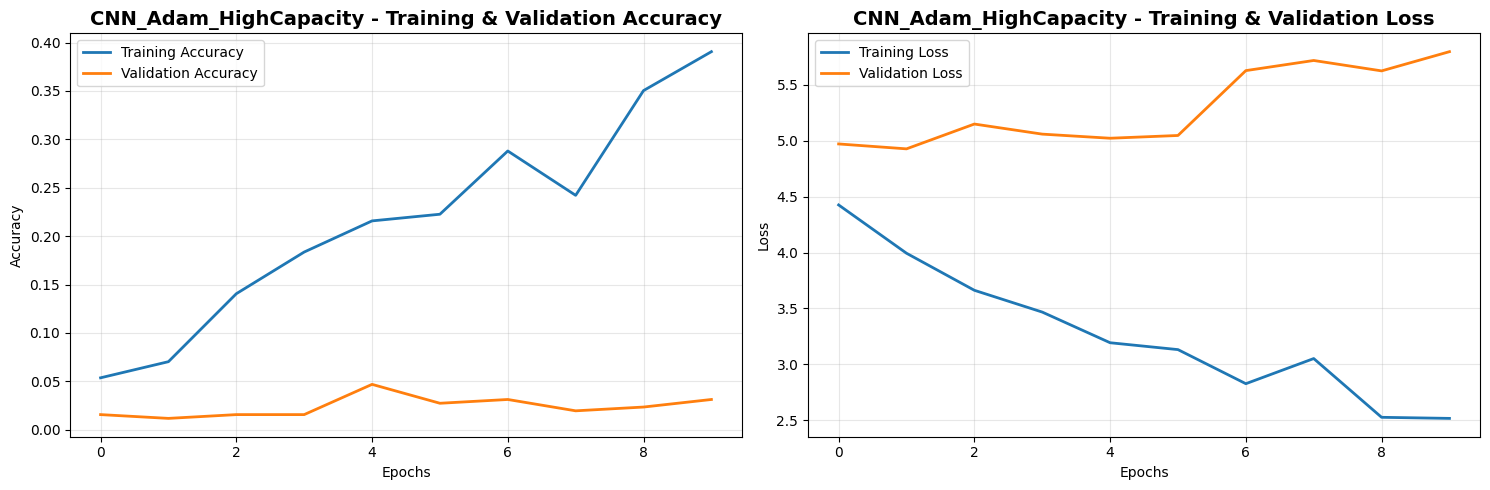

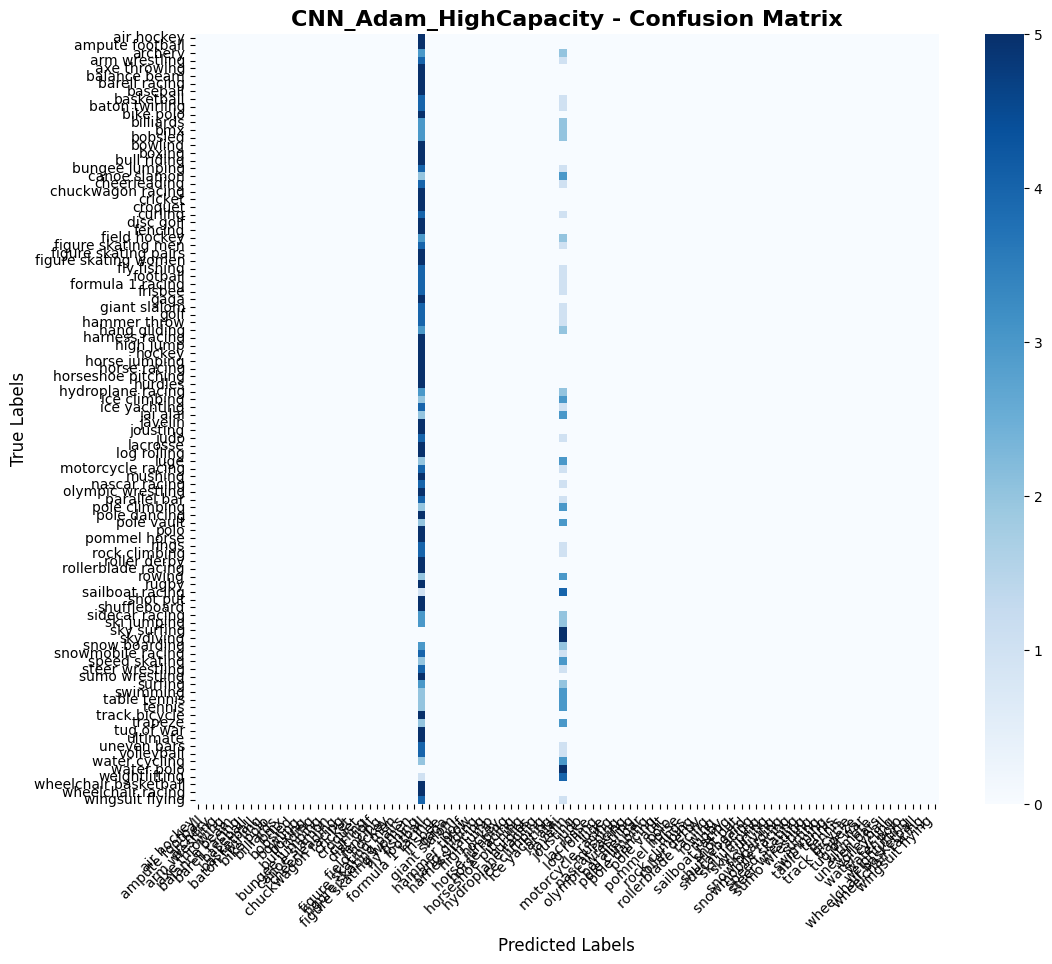

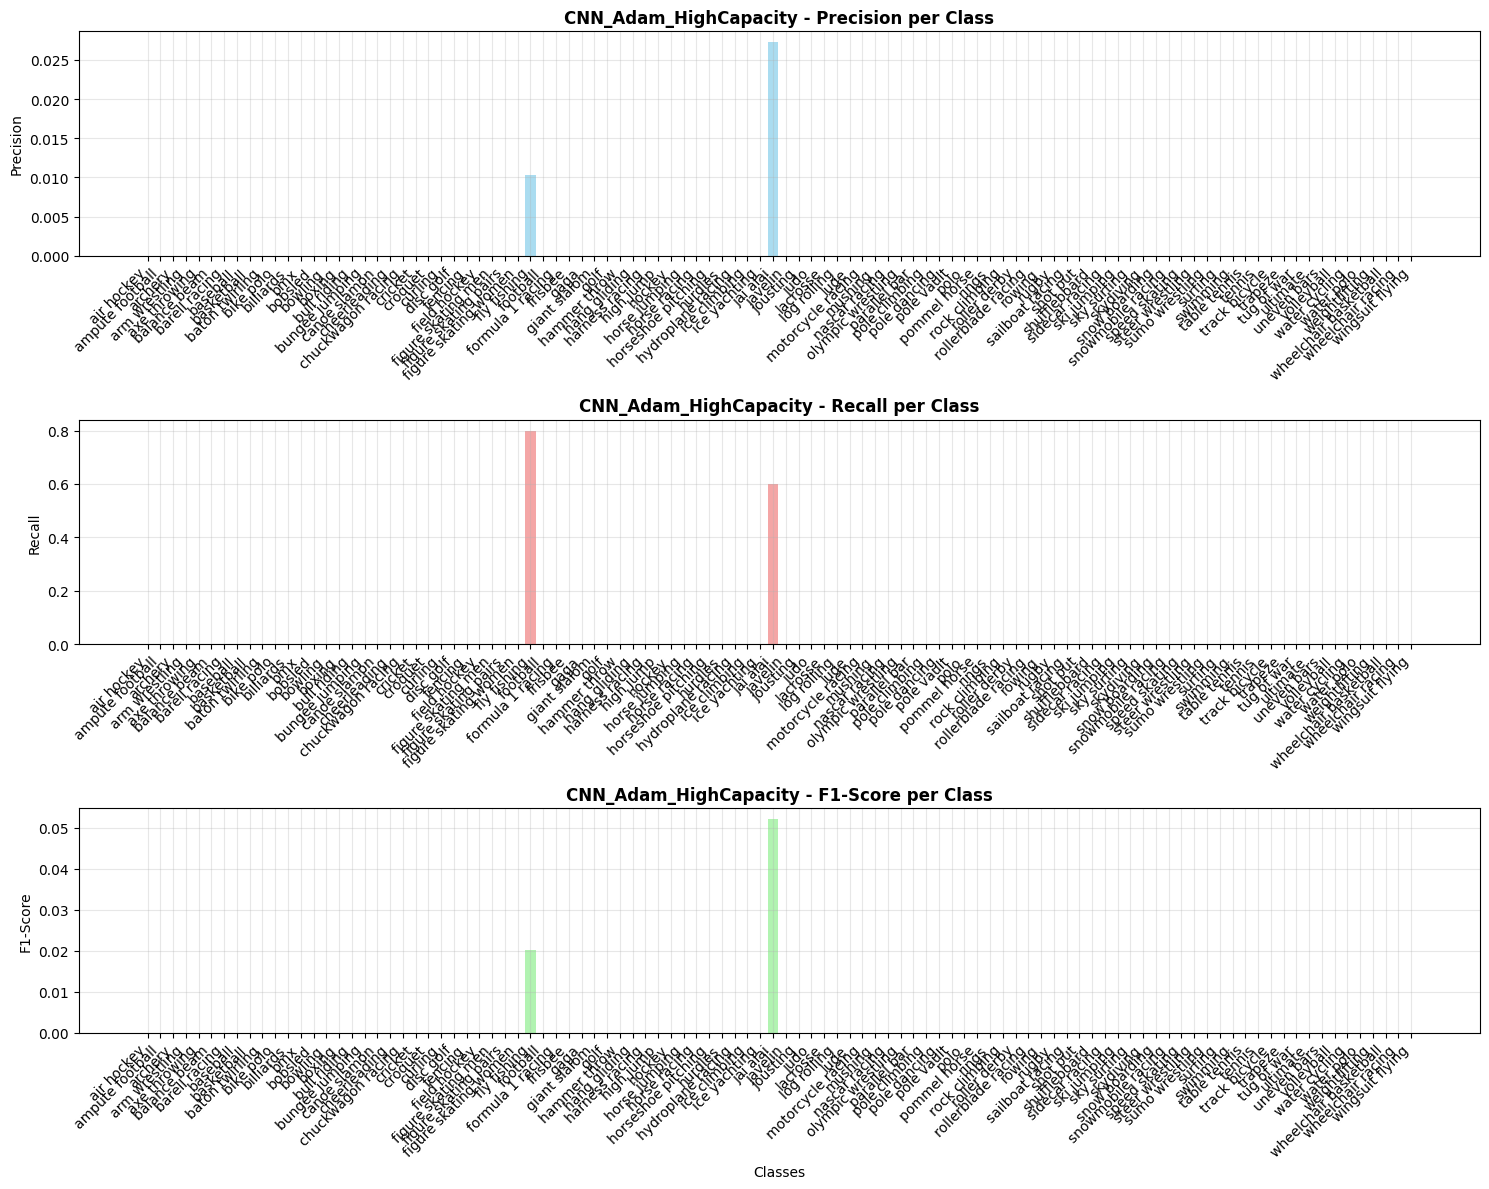


📋 DETAILED CLASSIFICATION REPORT FOR CNN_Adam_HighCapacity:
                       precision    recall  f1-score   support

           air hockey     0.0000    0.0000    0.0000         5
      ampute football     0.0000    0.0000    0.0000         5
              archery     0.0000    0.0000    0.0000         5
        arm wrestling     0.0000    0.0000    0.0000         5
         axe throwing     0.0000    0.0000    0.0000         5
         balance beam     0.0000    0.0000    0.0000         5
        barell racing     0.0000    0.0000    0.0000         5
             baseball     0.0000    0.0000    0.0000         5
           basketball     0.0000    0.0000    0.0000         5
       baton twirling     0.0000    0.0000    0.0000         5
            bike polo     0.0000    0.0000    0.0000         5
            billiards     0.0000    0.0000    0.0000         5
                  bmx     0.0000    0.0000    0.0000         5
              bobsled     0.0000    0.0000    0.0000    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [92]:
model_name_3 = "CNN_Adam_HighCapacity"
results_3 = evaluate_model(model_3, model_name_3, history_3, test_gen, class_labels)

# Generate plots for model 3
print(f"\n📊 GENERATING PLOTS FOR {model_name_3}")

# 1. Training history plots
plot_training_history(model_name_3, history_3.history)

# 2. Confusion matrix
plot_confusion_matrix(model_name_3, results_3['confusion_matrix'], class_labels)

# 3. Per-class metrics
plot_per_class_metrics(
    model_name_3,
    results_3['precision_per_class'],
    results_3['recall_per_class'],
    results_3['f1_per_class'],
    class_labels
)

# 4. Print detailed classification report
print(f"\n📋 DETAILED CLASSIFICATION REPORT FOR {model_name_3}:")
print("="*80)
print(classification_report(
    results_3['y_true'],
    results_3['y_pred'],
    target_names=class_labels,
    digits=4
))

# =============================================================================
# COMPARE ALL 3 MODELS
# =============================================================================

print(f"\n🏆 COMPARISON OF ALL MODELS:")
print("="*80)
comparison_data = []

for name, results in model_results.items():
    comparison_data.append({
        'Model': name,
        'Test_Accuracy': f"{results['test_accuracy']:.4f}",
        'F1_Macro': f"{results['f1_macro']:.4f}",
        'F1_Micro': f"{results['f1_micro']:.4f}",
        'Precision_Macro': f"{results['precision_macro']:.4f}",
        'Recall_Macro': f"{results['recall_macro']:.4f}"
    })

# Create comparison DataFrame
import pandas as pd
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print(f"\n📊 Best performing model: {max(model_results.keys(), key=lambda x: model_results[x]['test_accuracy'])}")